Notebook used to train RF models from the training data.

Comments throughout explain where changes can be made to change what's being trained!

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stat
import numpy as np 
#import forestsci
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter

import sys
sys.path.append("..")
import Utility.model_utils as model_utils

In [8]:
# Runtime Variables
seed = 72
accuracy_array = []

# Data Input
filename = '../Results/training_data.csv'

# If saving model, set save to True and give meaningful name
model_name = 'RF_C_MC.sav'
save = False 


# Control what features are used by the model
label="Labels"
features=['area',
#        'equivalent_diameter', 
#        'orientation', 
    'major_axis_length',
    'minor_axis_length',
    'perimeter',
 #       'min_intensity',
  #      'mean_intensity',
        'max_intensity',
    'solidity',
    'major_axis_length/minor_axis_length',
    'perimeter/major_axis_length',
    'perimeter/minor_axis_length',
          'feret_diameter_max',
      'moments_hu-0',
      'moments_hu-1',
      'moments_hu-2',
#      'moments_hu-3',
#      'moments_hu-4',
#      'moments_hu-5',
#      'moments_hu-6',
#    'eccentricity'
         ]


In [13]:
best_f1 = 0
best_model = None
for seed in np.arange(20):
    # Read in data w/ features
    df = pd.read_csv(filename)

    # Modify Data (Remove illegal data OR set different runtime)

    
    # Change how data is grouped
    df['Labels'].replace('Poorly Segmented', 'Incomplete', inplace=True) # Group Poorly Segmented and Incomplete as a single class
    df['Labels'].replace('Multiple Crystal', 'Crystal', inplace=True) # Group Multiple Crystal and Crystal as a single class
    #df = df[df['Labels'] != "Incomplete"] # Remove any data labeled as "Incomplete"
    
    # Missed Labels: Purge any bad data that the model cannot run on
    df['Labels'].replace('', np.nan, inplace=True) 
    df.dropna(subset=['Labels'], inplace=True)
    # Numerical errors (divide by 0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for feature in features:
        df.dropna(subset=[feature],inplace=True)

    # Split Data
    X=df[features]
    y=df[label]
    
    print(Counter(y))

    # Encode
    ohe = OneHotEncoder(sparse=False)
    #y = ohe.fit_transform(df[[label]])

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

    # Create RandomForestRegressor
    clf = svm.SVC(kernel='poly',random_state=seed)
    clf.fit(X_train,y_train)

    # Accuracy Checks
    y_pred=clf.predict(X_test)
    #y_pred = np.round(y_pred)
    
    accuracy = metrics.f1_score(y_test,y_pred,average='macro')
    accuracy_array.append(accuracy)
    #accuracy = metrics.accuracy_score(y_test,y_pred)
    print(f'{seed} Seed Completed')
    #model_utils.success_of_guess(y_pred,y_test,ohe)
    print(f'Running Average F1: {np.average(accuracy_array)}')
    
    if accuracy > best_f1:
        best_model = clf
        best_f1 = accuracy

Counter({'Crystal': 754, 'Incomplete': 413})
0 Seed Completed
Running Average F1: 0.5863438078016259
Counter({'Crystal': 754, 'Incomplete': 413})
1 Seed Completed
Running Average F1: 0.5785150554895608
Counter({'Crystal': 754, 'Incomplete': 413})
2 Seed Completed
Running Average F1: 0.5721696239163649
Counter({'Crystal': 754, 'Incomplete': 413})
3 Seed Completed
Running Average F1: 0.5653275843259004
Counter({'Crystal': 754, 'Incomplete': 413})
4 Seed Completed
Running Average F1: 0.5589742618490404
Counter({'Crystal': 754, 'Incomplete': 413})
5 Seed Completed
Running Average F1: 0.5534923907507976
Counter({'Crystal': 754, 'Incomplete': 413})
6 Seed Completed
Running Average F1: 0.548324563844023
Counter({'Crystal': 754, 'Incomplete': 413})
7 Seed Completed
Running Average F1: 0.5433393322174316
Counter({'Crystal': 754, 'Incomplete': 413})
8 Seed Completed
Running Average F1: 0.5385670093356367
Counter({'Crystal': 754, 'Incomplete': 413})
9 Seed Completed
Running Average F1: 0.53388954

In [4]:
print(f'Best Model F1: {best_f1}')
#print(best_model.oob_score_)
print(best_model.score(X_test,y_test))
#print(ohe)
#print(ohe.feature_names_in_)
#ohe.get_feature_names_out(['Labels'])

Best Model F1: 0.6666666666666666
0.6666666666666666


In [5]:
# Feature Importances

from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=2)
elapsed_time = time.time() - start_time

print(f'Time elapsed: {elapsed_time}')
forest_importances = pd.Series(result.importances_mean, index=features)

Time elapsed: 3.9382436275482178


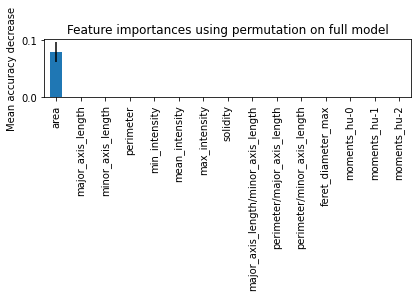

In [6]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [7]:
import pickle
if save:
    pickle.dump(best_model, open(model_name, 'wb'))